<a href="https://colab.research.google.com/github/amannain122/claim_fraud_detection/blob/main/notebooks/claims_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

client = storage.Client()
bucket = client.bucket("claims_fraud_data")

blob = bucket.blob("encoded_claim_data.csv")
blob.download_to_filename("encoded_claim_data.csv")

df = pd.read_csv("encoded_claim_data.csv")

In [3]:
df.head()

,Reco_Policy_Premium,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,class,age_group,City_Code_C10,...,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9
0,9.692828,0,0,0,3,6,4.0,0.0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,9.735128,1,0,0,0,7,3.0,1.0,4,0,...,0,0,0,0,0,0,0,0,0,0
2,10.153039,0,0,0,2,3,1.0,0.0,5,1,...,0,0,0,0,0,0,0,0,0,0
3,9.774961,0,1,1,0,15,1.0,0.0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,9.454306,1,0,0,0,3,2.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Unscaled Data

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Isolation Forest

In [60]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, f1_score


ift = IsolationForest(contamination=0.5, random_state=42)
ift.fit(X_train)

ift_train_pred = ift.predict(X_train)
ift_test_pred = ift.predict(X_test)

# Convert predictions to binary labels
ift_train_pred[ift_train_pred == 1] = 0
ift_train_pred[ift_train_pred == -1] = 1
ift_test_pred[ift_test_pred == 1] = 0
ift_test_pred[ift_test_pred == -1] = 1

print(f"F1 Score on Train Set: {f1_score(y_train, ift_train_pred)}")
print(f"F1 Score on Test Set: {f1_score(y_test, ift_test_pred)}")

F1 Score on Train Set: 0.3263933605208557
F1 Score on Test Set: 0.3375430539609644


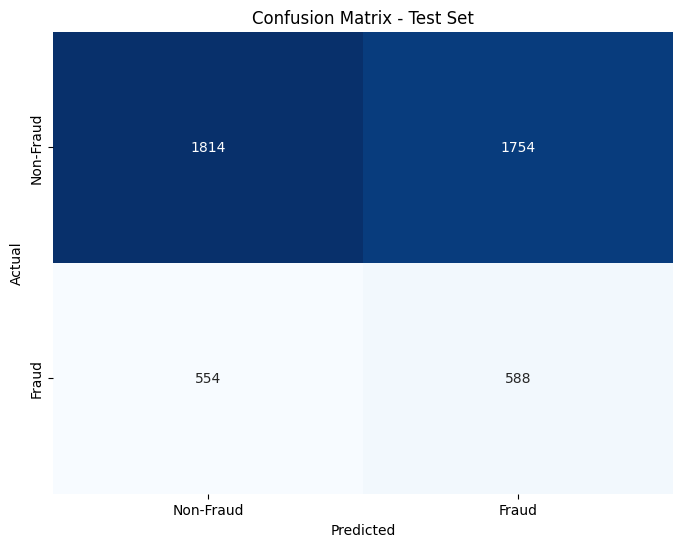

In [57]:
# Confusion Matrix
cm_test = confusion_matrix(y_test, ift_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

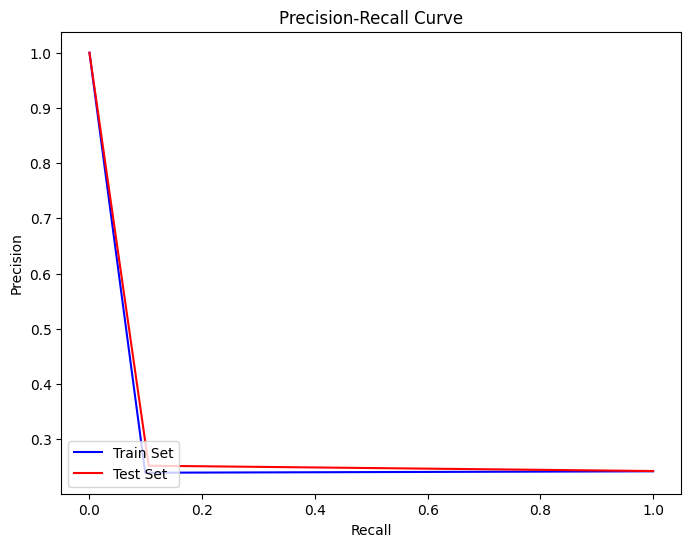

In [20]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve for train and test sets
precision_train, recall_train, _ = precision_recall_curve(y_train, ift_train_pred)
precision_test, recall_test, _ = precision_recall_curve(y_test, ift_test_pred)


plt.figure(figsize=(8,6))
plt.plot(recall_train, precision_train, label='Train Set', color='blue')
plt.plot(recall_test, precision_test, label='Test Set', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## One Class SVM

In [65]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, f1_score

ocs_svm = OneClassSVM(nu=0.4, kernel='rbf', gamma='scale')
ocs_svm.fit(X_train)

ocs_svm_train_pred = ocs_svm.predict(X_train)
ocs_svm_test_pred = ocs_svm.predict(X_test)

ocs_svm_train_pred[ocs_svm_train_pred == 1] = 1
ocs_svm_train_pred[ocs_svm_train_pred == -1] = 0
ocs_svm_test_pred[ocs_svm_test_pred == 1] = 1
ocs_svm_test_pred[ocs_svm_test_pred == -1] = 0

print(f"F1 Score on Train Set: {f1_score(y_train, ocs_svm_train_pred)}")
print(f"F1 Score on Test Set: {f1_score(y_test, ocs_svm_test_pred)}")

F1 Score on Train Set: 0.3501891551071879
F1 Score on Test Set: 0.3322540473225405


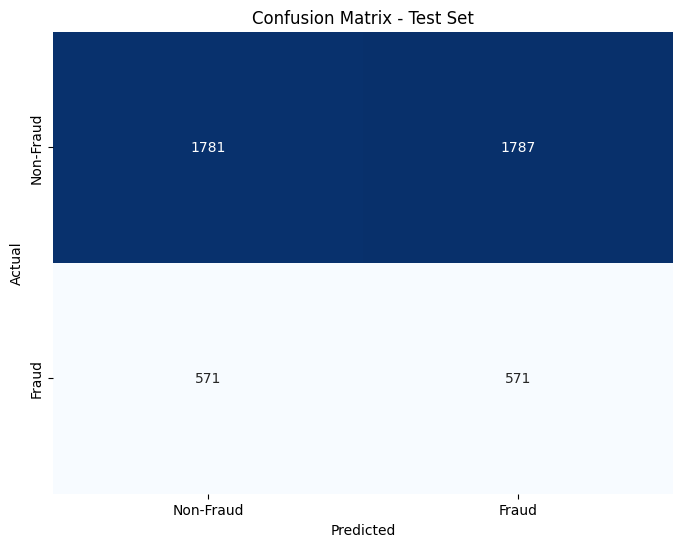

In [49]:
#Confusion Matrix

cm_svm_test = confusion_matrix(y_test, ocs_svm_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm_svm_test, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

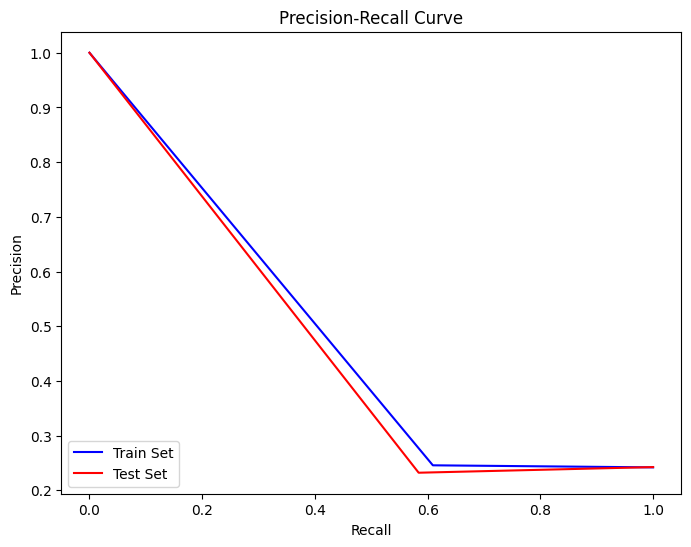

In [67]:
# Precision-Recall Curve for train and test sets
precision_train, recall_train, _ = precision_recall_curve(y_train, ocs_svm_train_pred)
precision_test, recall_test, _ = precision_recall_curve(y_test, ocs_svm_test_pred)


plt.figure(figsize=(8,6))
plt.plot(recall_train, precision_train, label='Train Set', color='blue')
plt.plot(recall_test, precision_test, label='Test Set', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [68]:
import joblib

joblib.dump(ocs_svm, 'best_model.pkl')
joblib.dump(ift, "iso_forest.pkl")

blob = bucket.blob("best_model.pkl")
blob.upload_from_filename("best_model.pkl")

blob = bucket.blob("iso_forest.pkl")
blob.upload_from_filename("iso_forest.pkl")

# Scaled Data

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## AutoEncoders - In Developement

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense